In [22]:
# This StackOveflow is about to read PRISM data on python
# https://stackoverflow.com/questions/23816545/reading-zipped-esri-bil-files-with-python

# Data comes from http://www.prism.oregonstate.edu/

import rasterio

ds = rasterio.open('PRISM data\Daily1991\PRISM_ppt_stable_4kmD2_19910101_bil.bil')
print(ds.count)
print(ds.width)
print(ds.height)
print(ds.bounds)
# To read into a numpy array
# band1 = ds.read(1)

# transform is a matrix that map pixel coordinates to spatial positions in meters
print(ds.transform)
# print(ds.transform*[0,0]) # upper left  Doesnt work
# print(ds.transform*[ds.width,ds.height]) # lower right
print(ds.crs) # Indicate coordinate system

1
1405
621
BoundingBox(left=-125.02083333333333, bottom=24.06249999999996, right=-66.47916666666197, top=49.93750000000203)
[-125.02083333333333, 0.04166666666667, 0.0, 49.93750000000203, 0.0, -0.04166666666667]
CRS({'init': 'epsg:4269'})


C:\Users\nicol\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [50]:
# ds.transform got changed into ds.affine

print(ds.affine)
print(ds.affine*[0,0])
print(ds.affine*[1405,621])
print(ds.affine[0],ds.affine[1],ds.affine[2],ds.affine[3],ds.affine[4],ds.affine[5])

| 0.04, 0.00,-125.02|
| 0.00,-0.04, 49.94|
| 0.00, 0.00, 1.00|
(-125.02083333333333, 49.93750000000203)
(-66.47916666666197, 24.06249999999996)
0.04166666666667 0.0 -125.02083333333333 0.0 -0.04166666666667 49.93750000000203


In [23]:
band1 = ds.read(1)
print(band1)

[[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]]


In [31]:
print((-66.47916666666197+125.02083333333333)/1405)
print((49.93750000000203-24.06249999999996)/621)
print((49.93750000000203-24.06249999999996)/621*24) # 1/24

0.04166666666667001
0.04166666666667
1.00000000000008


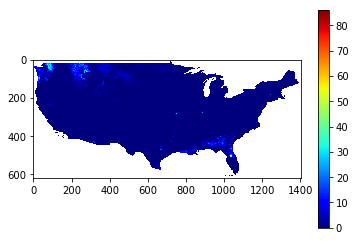

In [39]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

masked_array = np.ma.array(band1, mask=(band1==-9999.))
plt.imshow(masked_array, cmap=cm.jet)
cb = plt.colorbar()

In [42]:
band2 = ds.read(2)
masked_array = np.ma.array(band2, mask=(band2==-9999.))
plt.imshow(masked_array, cmap=cm.jet)
cb = plt.colorbar()

IndexError: band index out of range

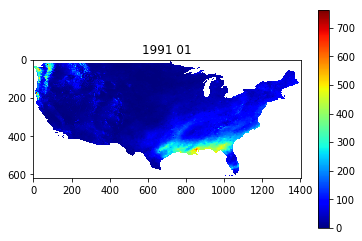

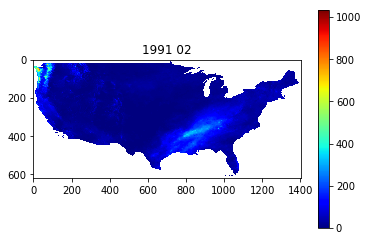

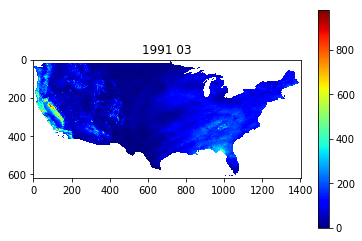

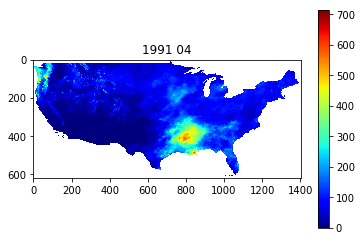

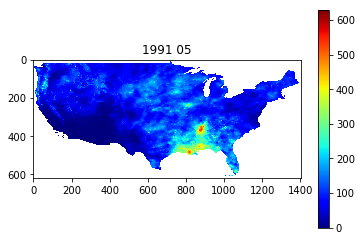

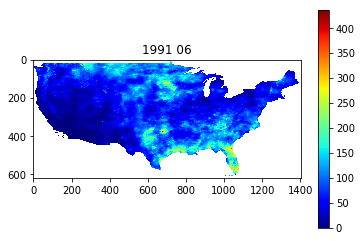

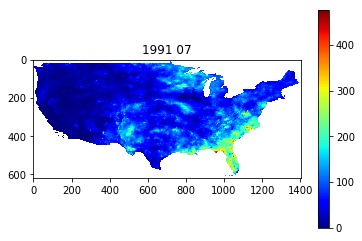

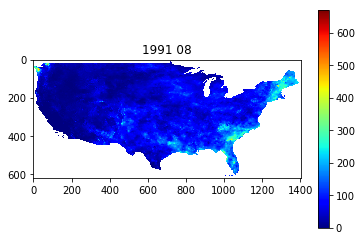

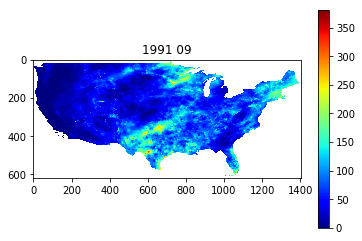

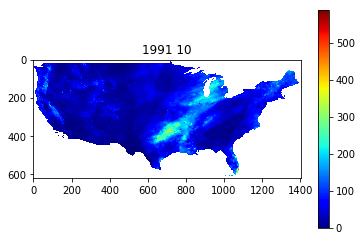

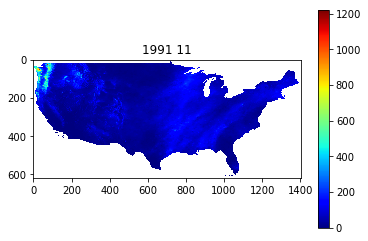

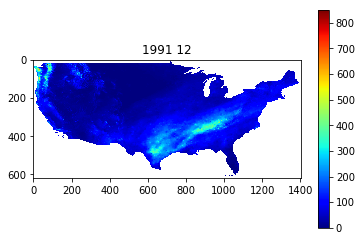

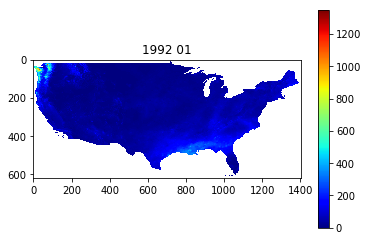

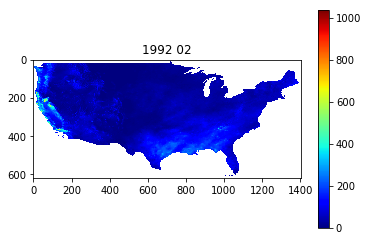

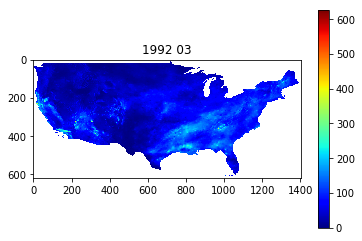

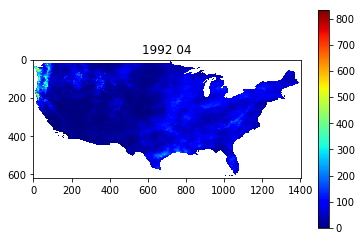

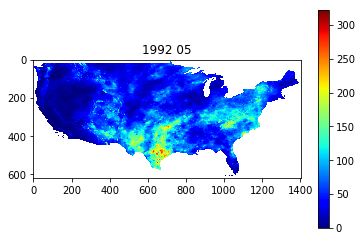

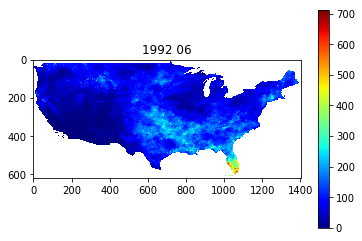

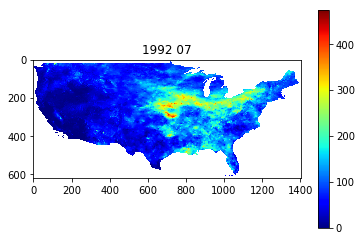

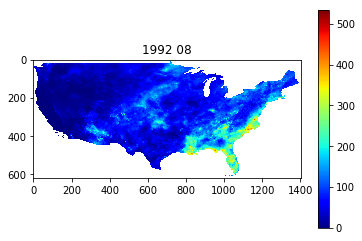

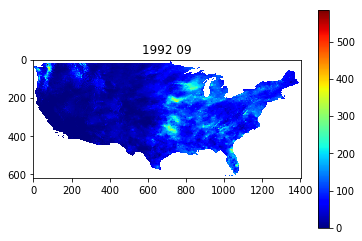

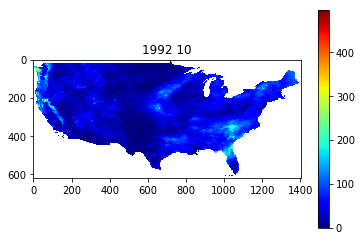

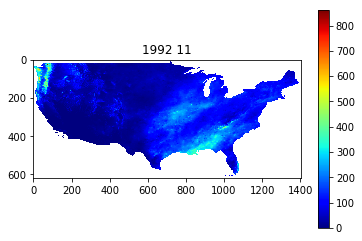

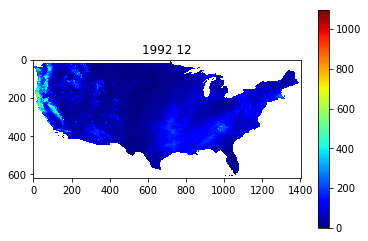

In [44]:
for year in range(1991,1993):
  for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    ds = rasterio.open('PRISM data\MonthlyAllYears\PRISM_ppt_stable_4kmM3_'+str(year)+month+'_bil.bil')
    band1 = ds.read(1)
    masked_array = np.ma.array(band1, mask=(band1==-9999.))
    plt.imshow(masked_array, cmap=cm.jet)
    cb = plt.colorbar()
    plt.title(str(year)+' '+month)
    plt.show()
    
# It looks like precipitation only. Maybe that's the meaning of ppt.

# Prepare input and output data for machine learning

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline
import rasterio

In [4]:
# data should be split into region of latitude and longitude. Each month should be separated.

ny = 39 # Will give steps of 16 or 17
nx = 88 # Will give steps of 16 or 17
ybin = np.linspace(0,621,ny, dtype=int)
xbin = np.linspace(0,1405,nx, dtype=int)
affine = rasterio.open('PRISM\PRISM_ppt_stable_4kmM3_198102_bil.bil').affine
latbin = ybin*affine[4]+affine[5]
longbin = xbin*affine[0]+affine[2]

In [5]:
tmp = []
for ix in range(nx-1):
  for iy in range(ny-1):
    tmp.append([ybin[iy]-ybin[iy+1],xbin[ix]-xbin[ix+1]])
tmp = np.asarray(tmp)
print(np.mean(tmp[:,0]),np.mean(tmp[:,1]),np.std(tmp[:,0]),np.std(tmp[:,1]))

-16.3421052632 -16.1494252874 0.474414641508 0.356507182052


In [6]:
# prepare time bin
nyear=2
day = np.asarray([1,32,60,91,121,152,182,213,244,274,305,335])
leapyearday = np.asarray([1,32,61,92,122,153,183,214,245,275,306,336])
timebin = []
# It means December 31st 1991 (one day before January 1st 1992) is: 2448622.5
# I'll start at 2448622
previousday = 2448622
for i in range(nyear):
    if nyear%4 != 0:
        timebin += list(day+previousday)
        previousday += 365
    else:
        timebin += list(leapyearday+previousday)
        previousday += 366

# Add next January first to serve as next end of bin
timebin += [previousday+1]

print(timebin)

[2448623, 2448654, 2448682, 2448713, 2448743, 2448774, 2448804, 2448835, 2448866, 2448896, 2448927, 2448957, 2448988, 2449019, 2449047, 2449078, 2449108, 2449139, 2449169, 2449200, 2449231, 2449261, 2449292, 2449322, 2449353]


In [7]:
# Prepare output data Phase 1
import sqlite3
import pandas as pd

conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
c = conn.cursor()

#c.execute('''SELECT DISCOVERY_DATE, FIRE_SIZE, LATITUDE, LONGITUDE, CONT_DATE-DISCOVERY_DATE   
c.execute('''SELECT DISCOVERY_DATE, FIRE_SIZE, LATITUDE, LONGITUDE 
FROM FIRES''')
rows = c.fetchall()
df = pd.DataFrame(rows)
#df.columns = ['time', 'size', 'lat', 'lon','duration']
df.columns = ['time', 'size', 'lat', 'lon']

# drop Alaska, Hawaii, Puerto Rico
# Or maybe use BoundingBox(left=-125.02083333333333, bottom=24.06249999999996, right=-66.47916666666197, top=49.93750000000203)
df = df[df['lon']>-130.]
df = df[df['lat']>24.]
df = df[df['lat']<50.]

# Look at max-min latitude and longitude
print(df['lon'].max())
print(df['lon'].min())
print(df['lat'].max())
print(df['lat'].min())

-66.970889
-124.71861
49.34335784
24.58166997


In [8]:
print(longbin) # It's growing
print(latbin) # It's going down

[-125.02083333 -124.35416667 -123.6875     -123.02083333 -122.35416667
 -121.6875     -121.02083333 -120.3125     -119.64583333 -118.97916667
 -118.3125     -117.64583333 -116.97916667 -116.3125     -115.60416667
 -114.9375     -114.27083333 -113.60416667 -112.9375     -112.27083333
 -111.60416667 -110.89583333 -110.22916667 -109.5625     -108.89583333
 -108.22916667 -107.5625     -106.85416667 -106.1875     -105.52083333
 -104.85416667 -104.1875     -103.52083333 -102.85416667 -102.14583333
 -101.47916667 -100.8125     -100.14583333  -99.47916667  -98.8125
  -98.14583333  -97.4375      -96.77083333  -96.10416667  -95.4375
  -94.77083333  -94.10416667  -93.39583333  -92.72916667  -92.0625
  -91.39583333  -90.72916667  -90.0625      -89.39583333  -88.6875
  -88.02083333  -87.35416667  -86.6875      -86.02083333  -85.35416667
  -84.6875      -83.97916667  -83.3125      -82.64583333  -81.97916667
  -81.3125      -80.64583333  -79.9375      -79.27083333  -78.60416667
  -77.9375      -77.27

In [21]:
# Prepare output data in xybin
output = []
loc = []
MinNFireInCell = 10
for ix in range(nx-1):
    for iy in range(ny-1):
        tmp = df[ (df['lon']>longbin[ix]) &  (df['lon']<longbin[ix+1]) &  (df['lat']<latbin[iy]) &  
                 (df['lat']>latbin[iy+1]) ]
        if tmp.size < MinNFireInCell:
            continue
        dataT = []
        for it in range(len(timebin)-1):
            tmp2 = tmp[(tmp['time']>timebin[it]) & (tmp['time']<timebin[it+1])]
            if tmp2.empty:
                dataT.append(0)
                continue
            dataT.append(np.sum(tmp2['size'].values))
        output.append(np.array(dataT))
        loc.append((ix, iy))
output = np.array(output)
loc = np.array(loc)
print(output.shape)
print(loc.shape)

(1930, 24)
(1930, 2)


In [22]:
# Prepare input data
data = np.empty((4, 621,1405,12*nyear))
itime = 0
for year in range(1992,1992+nyear):
  for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    ds1 = rasterio.open('PRISM\PRISM_ppt_stable_4kmM3_'+str(year)+month+'_bil.bil')
    ds2 = rasterio.open('PRISM\PRISM_tmax_stable_4kmM2_'+str(year)+month+'_bil.bil')
    ds3 = rasterio.open('PRISM\PRISM_tmean_stable_4kmM2_'+str(year)+month+'_bil.bil')
    ds4 = rasterio.open('PRISM\PRISM_tmin_stable_4kmM2_'+str(year)+month+'_bil.bil')
    #print(np.array([ds1.read(1),ds2.read(1),ds3.read(1),ds4.read(1)]).shape)
    data[:,:,:,itime] = np.array([ds1.read(1),ds2.read(1),ds3.read(1),ds4.read(1)])
    itime += 1
    
inputData = [] 
for ix, iy in loc:
    # array works only if ybin[iy+1]-ybin[iy] is a constant, same for xbin. If not we can only have a list since the shape
    # doesn't stay the same.
    # It's 16 or 17 right now. I'll just forget about last row
    
    #tmp = data[ybin[iy]:ybin[iy+1],xbin[ix]:xbin[ix+1],:]
    tmp = data[:,ybin[iy]:ybin[iy]+16,xbin[ix]:xbin[ix]+16,:]
    inputData.append(tmp)

inputData = np.array(inputData)
print(inputData.shape)

(1930, 4, 16, 16, 24)


In [26]:
inputData0 = np.ma.array(inputData, mask=(inputData==-9999.))

In [ ]:
# I'm planning to save that into a file that I will give to my tensorflow notebook.
# I need to have: input, loc, output
# input is of shape (xyBigBin, channel, y position in BigBin, x position in BigBin, time)
# channel is for: precipitation, tmin, tmax, tmean
# loc is useful before I will use it in my neuro-network since it's important data.

# I should increase nyear to 24 (1992-2015), then time will be 24*12=288

# Verify that input and output are good

In [35]:
# Look at max and min value to do colorbar

print(np.max(inputData0[:,0,:,:,:]))
print(np.max(inputData0[:,1,:,:,:]))
print(np.max(inputData0[:,2,:,:,:]))
print(np.max(inputData0[:,3,:,:,:]))
print(np.max(output[:,:]))
print(np.min(inputData0[:,0,:,:,:]))
print(np.min(inputData0[:,1,:,:,:]))
print(np.min(inputData0[:,2,:,:,:]))
print(np.min(inputData0[:,3,:,:,:]))
print(np.min(output[:,:]))

1346.2800293
46.8600006104
37.9449996948
30.3700008392
198306.0
0.0
-12.970000267
-19.1499996185
-28.1599998474
0.0


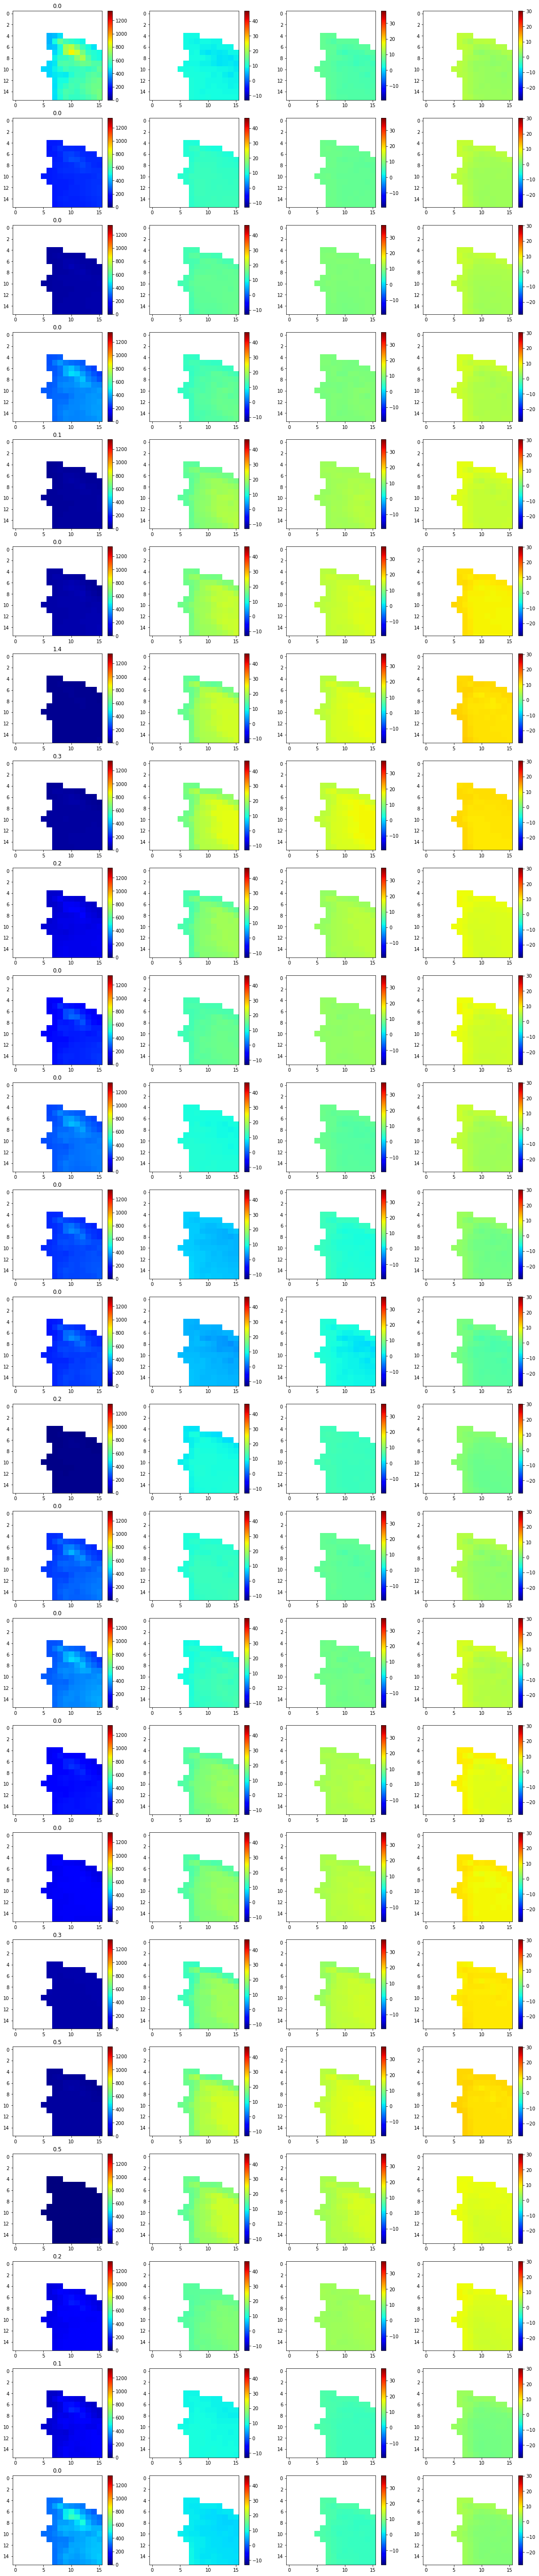

In [41]:
# First bin
from matplotlib import cm, colors
nfigures = 4
fig = plt.figure(figsize=(20,100))
for i in range(24):
    fig.add_subplot(24,nfigures,nfigures*i+1)
    plt.title(output[0,i])
    plt.imshow(inputData0[0,0,:,:,i], cmap=cm.jet, vmin=0.0, vmax=1346.2800293)
    plt.colorbar()
    fig.add_subplot(24,nfigures,nfigures*i+2)
    plt.imshow(inputData0[0,1,:,:,i], cmap=cm.jet, vmin=-12.970000267, vmax=46.8600006104)
    plt.colorbar()
    fig.add_subplot(24,nfigures,nfigures*i+3)
    plt.imshow(inputData0[0,2,:,:,i], cmap=cm.jet, vmin=-19.1499996185, vmax=37.9449996948)
    plt.colorbar()
    fig.add_subplot(24,nfigures,nfigures*i+4)
    plt.imshow(inputData0[0,3,:,:,i], cmap=cm.jet, vmin=-28.1599998474, vmax=30.3700008392)
    plt.colorbar()
    #fig.add_subplot(24,5,5*i+5)
    #plt.imshow(output[0,i][np.newaxis,np.newaxis], cmap=cm.jet, vmin=0.0, vmax=198306.0)
    #plt.title(output[0,i])
    #plt.colorbar()

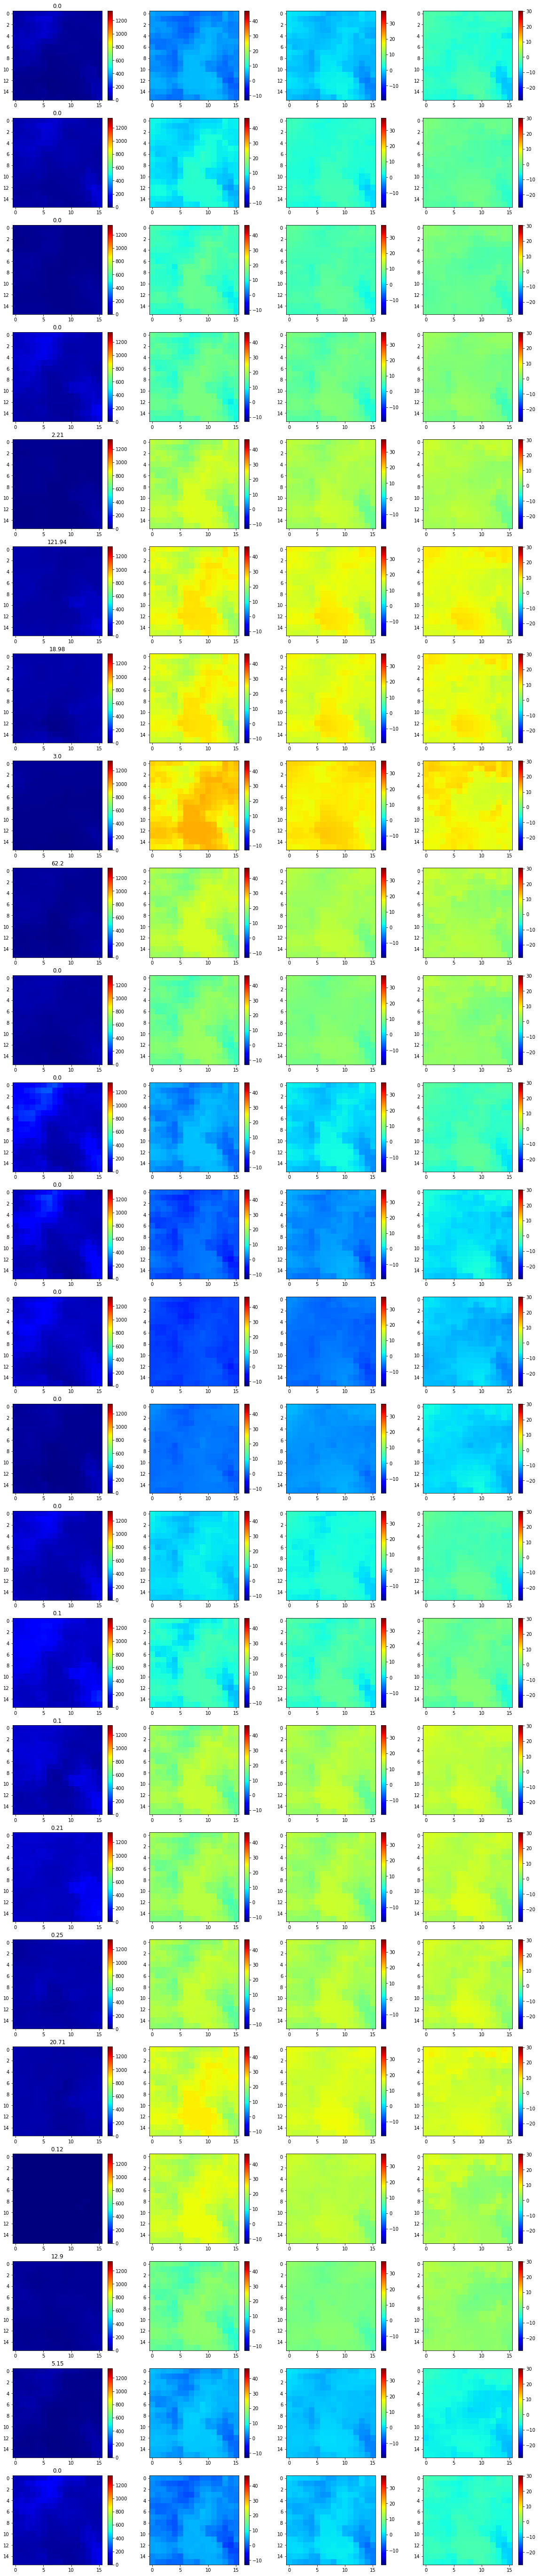

In [42]:
# Other bin
Bin = 195
nfigures = 4
fig = plt.figure(figsize=(20,100))
for i in range(24):
    fig.add_subplot(24,nfigures,nfigures*i+1)
    plt.title(output[Bin,i])
    plt.imshow(inputData0[Bin,0,:,:,i], cmap=cm.jet, vmin=0.0, vmax=1346.2800293)
    plt.colorbar()
    fig.add_subplot(24,nfigures,nfigures*i+2)
    plt.imshow(inputData0[Bin,1,:,:,i], cmap=cm.jet, vmin=-12.970000267, vmax=46.8600006104)
    plt.colorbar()
    fig.add_subplot(24,nfigures,nfigures*i+3)
    plt.imshow(inputData0[Bin,2,:,:,i], cmap=cm.jet, vmin=-19.1499996185, vmax=37.9449996948)
    plt.colorbar()
    fig.add_subplot(24,nfigures,nfigures*i+4)
    plt.imshow(inputData0[Bin,3,:,:,i], cmap=cm.jet, vmin=-28.1599998474, vmax=30.3700008392)
    plt.colorbar()

I don't think I need that much precision in xy.

I think I should have more precision in time. By day rather than by month.
    Use https://www.howtogeek.com/272176/how-to-connect-to-ftp-servers-in-windows-without-extra-software/
    and http://www.prism.oregonstate.edu/documents/PRISM_downloads_FTP.pdf
    to get all this data
    
Need to reboot windows after: No more handles can be allocated. It's a bug in windows ftp transfer system.

I think I should not use region like region 0 where only 1/4 of it is on the ground.

I need to look how to do time series analysis.